In [ ]:
pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  TRANSFER    181.0  C1305486145          181.0             0.0   
1     1  CASH_OUT    181.0   C840083671          181.0             0.0   
2     1  TRANSFER   2806.0  C1420196421         2806.0             0.0   
3     1  CASH_OUT   2806.0  C2101527076         2806.0             0.0   
4     1  TRANSFER  20128.0   C137533655        20128.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0   C553264065             0.0             0.0        1  
1    C38997010         21182.0             0.0        1  
2   C972765878             0.0             0.0        1  
3  C1007251739         26202.0             0.0        1  
4  C1848415041             0.0             0.0        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ste

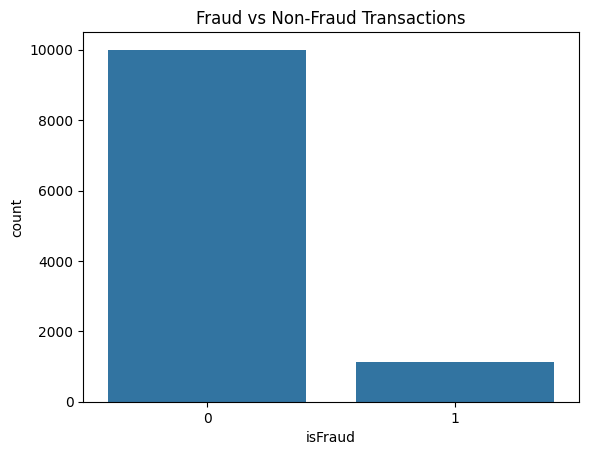

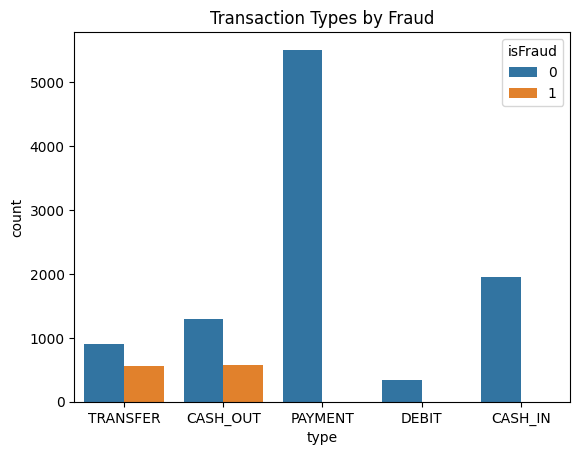

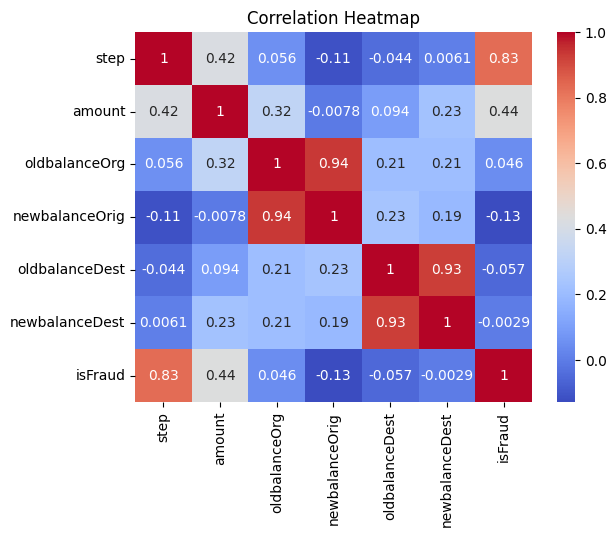

In [ ]:
df = pd.read_csv('Fraud_Analysis_Dataset.csv')

# Basic info
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Class distribution (imbalance check)
print(df['isFraud'].value_counts(normalize=True))

# Visualize fraud distribution
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

# Transaction types
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Types by Fraud')
plt.show()

# Correlation heatmap (numeric features)
numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Feature engineering
df['errorOrig'] = df['newbalanceOrig'] - (df['oldbalanceOrg'] - df['amount'])
df['errorDest'] = df['newbalanceDest'] - (df['oldbalanceDest'] + df['amount'])  # Adjust based on type if needed
df['isMerchant'] = df['nameDest'].apply(lambda x: 1 if str(x).startswith('M') else 0)

# Drop IDs and step (if not time-series modeling)
df = df.drop(['nameOrig', 'nameDest', 'step'], axis=1)

# Features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipeline
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorOrig', 'errorDest']
categorical_features = ['type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Full pipeline with SMOTE and model (RandomForest for starters)
model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [ ]:
# Train
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba)}')

# Precision-Recall AUC (better for imbalance)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc}')

# Feature importance (from RandomForest)
importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_names = numeric_features + list(model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
sorted_importance = sorted(zip(importances, feature_names), reverse=True)
print("Top features:", sorted_importance[:5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       0.99      0.98      0.98       228

    accuracy                           1.00      2229
   macro avg       0.99      0.99      0.99      2229
weighted avg       1.00      1.00      1.00      2229

ROC AUC: 0.9969412223712704
PR AUC: 0.9931739792256605
Top features: [(np.float64(0.27853253029224934), 'errorOrig'), (np.float64(0.20565049660692064), 'newbalanceOrig'), (np.float64(0.12133942346348334), 'type_PAYMENT'), (np.float64(0.10806662635725293), 'oldbalanceOrg'), (np.float64(0.0734018253069182), 'amount')]


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [10, 20]}
grid = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'classifier__max_depth': 10, 'classifier__n_estimators': 100}


In [ ]:
import joblib
joblib.dump(model_pipeline, 'fraud_model.pkl')

['fraud_model.pkl']

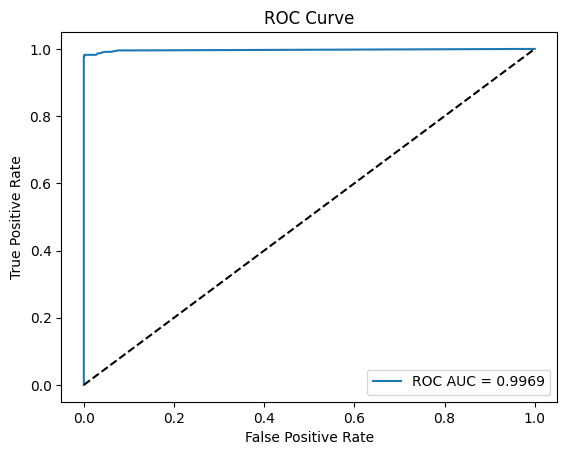

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
model_pipeline.set_params(classifier__n_estimators=100, classifier__max_depth=10)
model_pipeline.fit(X_train, y_train)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
print(f"ROC AUC (Tuned): {roc_auc_score(y_test, y_pred_proba)}")

ROC AUC (Tuned): 0.9982727934278475


In [ ]:
import joblib

# Load the model
model = joblib.load('fraud_model.pkl')

# Verify it loaded correctly (optional)
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import pandas as pd

# Sample data
new_data = {
    'type': ['TRANSFER'],
    'amount': [1000],
    'oldbalanceOrg': [2000],
    'newbalanceOrig': [1000],
    'oldbalanceDest': [0],
    'newbalanceDest': [1000],
    'nameDest': ['M123']
}
df_new = pd.DataFrame(new_data)

# Feature engineering
df_new['errorOrig'] = df_new['newbalanceOrig'] - (df_new['oldbalanceOrg'] - df_new['amount'])
df_new['errorDest'] = df_new['newbalanceDest'] - (df_new['oldbalanceDest'] + df_new['amount'])
df_new['isMerchant'] = df_new['nameDest'].apply(lambda x: 1 if str(x).startswith('M') else 0)
df_new = df_new.drop(['nameDest'], axis=1, errors='ignore')

# Predict
prediction = model.predict(df_new)
probability = model.predict_proba(df_new)[:, 1]

print(f"Prediction (0 = Non-Fraud, 1 = Fraud): {prediction[0]}")
print(f"Probability of Fraud: {probability[0]:.4f}")

Prediction (0 = Non-Fraud, 1 = Fraud): 0
Probability of Fraud: 0.2600
